In [1]:
import pandas as pd
import numpy as np
import os, sklearn

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from get_coords import get_coords

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#### Identify Directories

In [2]:
currDir = os.getcwd()
rootDir = os.path.abspath(os.path.join(currDir,'..'))

dataDir = os.path.abspath(os.path.join(rootDir,'data'))
rawDataDir = os.path.abspath(os.path.join(dataDir,'raw'))
interimDataDir = os.path.abspath(os.path.join(dataDir,'interim'))
finalDataDir = os.path.abspath(os.path.join(dataDir,'final'))

#### Helper Functions

In [3]:
def evaluate_model(model,X_train,y_train,cv_folds=5):
        
    predictions   = cross_val_predict(model, X_train, y_train, cv=cv_folds)

    cv_accuracies = cross_val_score(model, X_train, y_train, 
                                    cv=cv_folds, scoring="accuracy")
        
    conf_matrix = confusion_matrix(y_train, predictions)
    
    try:
        # only for binary classification
        precision = precision_score(y_train, predictions)
        recall    = recall_score(y_train, predictions)
    except:
        # for multi-class classification
        precision = precision_score(y_train, predictions, average=None)
        recall    = recall_score(y_train, predictions, average=None)
        

    #### PRINT KEY DATA ####
    
    print(f"{cv_folds} Cross Validations")
    print("Mean CV Accuracy",np.round(np.mean(cv_accuracies),2))
    print("CV Accuracies:",cv_accuracies)
    print("\n") 
    
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\n") 
    
    print("Precision Score:",np.round(precision,2))
    print('Recall Score:',np.round(recall,2))
    
    #### RETURN DATA
    
    return predictions, conf_matrix

#### Access Data

In [4]:
bbox = (-124,24,-67,50)

states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
          "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
          "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
          "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
          "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
          "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
          "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
          "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]
    

In [5]:
geo = get_coords(rawDataDir)
df  = geo.load_data()

print(geo.filename)
print(df.shape)

/Users/Michael/Documents/Projects/MLgeo/data/raw//reverse_US_geocode_results_pull7.csv
(15033, 9)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15033 entries, 0 to 15032
Data columns (total 9 columns):
area          13352 non-null object
city          15033 non-null object
country       15033 non-null object
gps_lat       15033 non-null float64
gps_long      15033 non-null float64
lat           15033 non-null float64
long          15033 non-null float64
state         15001 non-null object
state_flag    15033 non-null object
dtypes: float64(4), object(5)
memory usage: 1.0+ MB


In [7]:
df.head(2)

,area,city,country,gps_lat,gps_long,lat,long,state,state_flag
0,Shelby County,Timpson,US,31.78,-94.33,31.90378,-94.39520,Texas,Texas
1,Richland County,Olney,US,38.77,-88.01,38.73088,-88.08532,Illinois,Illinois


In [8]:
#df['state_flag'].value_counts()/len(df)

#### (Stratified) Train Test Split

In [9]:
'''
# separate data and labels into X and y arrays
X = df[['gps_lat','gps_long']].values
y = df['state_flag'].values

# perform NON-STRATIFIED train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)
'''

# perform stratified random shuffling 
splitter = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=42)
for train_idx,test_idx in splitter.split(df,df['state_flag']):
    strat_train_set = df.loc[train_idx]
    strat_test_set = df.loc[test_idx]

# create train/test sets from stratified shuffle
X_train, X_test = strat_train_set[['gps_lat','gps_long']].values, strat_test_set[['gps_lat','gps_long']].values
y_train, y_test = strat_train_set['state_flag'].values, strat_test_set['state_flag'].values

print("Training set size:",len(strat_train_set))
print("Test set size:",len(strat_test_set))

Training set size: 10523
Test set size: 4510


#### Binary Classifier

In [10]:
# True = USA 
# False = non-USA

y_train_binary = ~(y_train == 'None')
y_test_binary  = ~(y_test == 'None')

print("Training set size:",len(y_train_binary))
print("Test set size:",len(y_test_binary))

Training set size: 10523
Test set size: 4510


In [21]:
# fit stochastic gradient descent classifier
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=1000, tol=1e-3,
                        random_state=42,verbose=0)
sgd.fit(X_train, y_train_binary);


# fit random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_binary = RandomForestClassifier(n_estimators=100, random_state=42)
rf_binary.fit(X_train, y_train_binary);

# fit support vector machine classifier
from sklearn import svm

svc = svm.SVC(gamma='auto')
svc.fit(X_train, y_train_binary);


In [12]:
# make a prediction 
'''
k = 2019
pred = sgd.predict([X_test[k]])

print('Label:',y_test_binary[k])
print('Prediction:',pred[0])
'''

"\nk = 2019\npred = sgd.predict([X_test[k]])\n\nprint('Label:',y_test_binary[k])\nprint('Prediction:',pred[0])\n"

In [13]:
# evaluate SGD model
preds, conf_matrix = evaluate_model(sgd,X_train,y_train_binary,cv_folds=5)

5 Cross Validations
Mean CV Accuracy 0.66
CV Accuracies: [0.76342043 0.76674584 0.77624703 0.27410926 0.70851165]


Confusion Matrix:
[[ 559 1930]
 [1671 6363]]


Precision Score: 0.77
Recall Score: 0.79


In [14]:
# Evaluate binary RF model
preds, conf_matrix = evaluate_model(rf_binary,X_train,y_train_binary,cv_folds=5)

5 Cross Validations
Mean CV Accuracy 0.99
CV Accuracies: [0.99049881 0.98907363 0.99144893 0.98859857 0.99096529]


Confusion Matrix:
[[2426   63]
 [  41 7993]]


Precision Score: 0.99
Recall Score: 0.99


In [22]:
# Evaluate SVM model
preds, conf_matrix = evaluate_model(svc,X_train,y_train_binary,cv_folds=5)

# SVM (w/ gamma = 'auto' )performs only very slightly worse than binary RF

5 Cross Validations
Mean CV Accuracy 0.99
CV Accuracies: [0.9871734  0.9871734  0.98669834 0.98432304 0.98811222]


Confusion Matrix:
[[2410   79]
 [  61 7973]]


Precision Score: 0.99
Recall Score: 0.99


#### Multi-Class Classification

In [17]:
# perform random forest regression

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train);

In [18]:
# Evaluate RF model
preds, conf_matrix = evaluate_model(rf,X_train,y_train,cv_folds=5)

/Users/Michael/anaconda3/envs/web-scrape-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/Michael/anaconda3/envs/web-scrape-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


5 Cross Validations
Mean CV Accuracy 0.97
CV Accuracies: [0.9670898  0.96976854 0.96817102 0.9708413  0.97070125]


Confusion Matrix:
[[38  0  0 ...  0  0  0]
 [ 0 64  0 ...  0  0  0]
 [ 0  0 25 ...  0  0  0]
 ...
 [ 0  0  0 ... 11  0  0]
 [ 0  0  0 ...  0 30  0]
 [ 0  0  0 ...  0  0 60]]


Precision Score: [0.95 0.93 0.93 0.99 0.96 0.33 0.   0.95 0.88 0.89 0.9  0.75 0.94 0.96
 0.89 0.93 0.88 0.75 0.85 0.93 0.91 0.95 0.88 0.96 0.92 0.92 0.75 0.83
 0.95 0.8  0.97 0.93 0.94 0.96 0.83 0.98 0.93 0.   0.85 0.94 0.94 0.94
 0.92 0.8  0.9  0.97 1.   0.83 0.91]
Recall Score: [0.88 0.89 0.89 0.99 0.94 0.33 0.   0.97 0.88 0.92 0.88 0.83 0.98 0.96
 0.89 0.97 0.75 0.67 0.89 0.85 0.89 0.83 0.88 0.94 0.94 0.92 0.5  0.79
 0.98 0.83 0.98 0.92 0.94 0.93 0.93 0.98 0.93 0.   0.77 0.94 0.97 0.92
 0.98 0.8  0.97 0.97 0.85 0.77 0.9 ]


/Users/Michael/anaconda3/envs/web-scrape-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


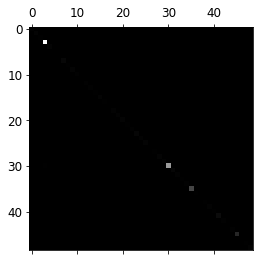

In [19]:
plt.matshow(conf_matrix, cmap=plt.cm.gray);

In [20]:
'''
PIPELINING

    stratified sampling with respect to US states
    create + save test set 
    shuffle training set
    add more data (check that pipeline can handle making test sets w/ added data)
    median imputer
    custom transformation
    standard data prep pipeline
    regular data prep pipeline
    
CLASSIFICATION
    
    BINARY - only in/out of US (stochastic GD algo)
    cross validation!
    model evaluation (accuracy + confusion matrix)
    understand precision + recall
    play around with decision thresholds
    come up with doofy custom estimator (and validate)
    MULTI-CLASS classification (and validate)
        SGD + RF + SVM
    plot random forest solution
    tune model (grid search)
    custom ensemble classifier
    
SPAM + HAM EXERCISE

'''

'\nPIPELINING\n\n    stratified sampling with respect to US states\n    create + save test set \n    shuffle training set\n    add more data (check that pipeline can handle making test sets w/ added data)\n    median imputer\n    custom transformation\n    standard data prep pipeline\n    regular data prep pipeline\n    \nCLASSIFICATION\n    \n    BINARY - only in/out of US (stochastic GD algo)\n    cross validation!\n    model evaluation (accuracy + confusion matrix)\n    understand precision + recall\n    play around with decision thresholds\n    come up with doofy custom estimator (and validate)\n    MULTI-CLASS classification (and validate)\n        SGD + RF + SVM\n    plot random forest solution\n    tune model (grid search)\n    \nSPAM + HAM EXERCISE\n\n'